In [59]:
import os

import numpy as np
from scipy import stats
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns

import ccsblib

from data_loading import (load_isoform_and_paralog_y2h_data,
                          load_valid_isoform_clones,
                          load_paralog_pairs,
                          load_ppi_partner_categories)
from plotting import y2h_ppi_per_paralog_pair_plot

%matplotlib inline
pd.set_option('display.max_columns', 50)

In [2]:
y2h = load_isoform_and_paralog_y2h_data()
isoforms = load_valid_isoform_clones()
pairs = load_paralog_pairs()

In [3]:
# filtered dataset
# remove partners with no positive tests per tf gene
# remove isoforms with no successful tests
# remove genes with < 2 isoforms
require_at_least_one_ppi_per_isoform = True
ppi = y2h.loc[(y2h['category'] == 'tf_isoform_ppis'), 
              ['ad_clone_acc',
               'ad_gene_symbol',
               'db_gene_symbol',
               'score']].copy()
ppi = ppi.loc[ppi.groupby(['ad_gene_symbol', 'db_gene_symbol'])
                 ['score']
                 .transform(lambda row: (row == '1').any()),
              :]
ppi = ppi.loc[ppi.groupby('ad_clone_acc')
                  ['score']
                  .transform(lambda x: (x.isin(['0', '1']).any())),
              :]
if require_at_least_one_ppi_per_isoform:
    ppi = ppi.loc[ppi.groupby('ad_clone_acc')['score'].transform(lambda x: (x == '1').any()),
                  :]
ppi = ppi.loc[ppi.groupby('ad_gene_symbol')
                 ['ad_clone_acc']
                 .transform(lambda x: x.nunique() >= 2),
              :]

In [179]:
# rewiring fraction
df = ppi.copy()
df['score'] = df['score'].map({'1': 1,
                               '0': 0,
                               'AA': np.nan,
                               'NC': np.nan})
partners = (df.groupby(['ad_gene_symbol', 'db_gene_symbol'])['score']
              .mean()
              .reset_index()
              .groupby('db_gene_symbol')
              .mean()
              .rename(columns={'score': 'rewiring_score'}))
partners['rewiring_score'] = 1. - partners['rewiring_score']
partners['rewiring_score_alt'] = (df.groupby(['ad_gene_symbol', 'db_gene_symbol'])['score']
                                    .all()
                                    .reset_index()
                                    .groupby('db_gene_symbol')
                                    .mean())
partners['rewiring_score_alt'] = 1. - partners['rewiring_score_alt']
partners['degree'] = (y2h.loc[(y2h['category'] == 'tf_isoform_ppis') &
                          (y2h['score'] == '1'),
                          ['ad_gene_symbol', 'db_gene_symbol']]
                     .groupby('db_gene_symbol')
                     ['ad_gene_symbol']
                     .nunique())
partners['degree_filtered'] = (df.loc[(df['score'] == 1),
                          ['ad_gene_symbol', 'db_gene_symbol']]
                     .groupby('db_gene_symbol')
                     ['ad_gene_symbol']
                     .nunique())
cats = load_ppi_partner_categories()
cats = cats.groupby('category')['partner'].apply(set).to_dict()
for cat, members in cats.items():
    partners['is_partner_category_' + '_'.join(cat.split())] = partners.index.isin(members)
if partners.isnull().any().any():
    raise ValueError('Did not expect missing data')

In [103]:
partners.head()

,rewiring_score,rewiring_score_alt,degree,is_partner_category_DNA_polymerase,is_partner_category_DNA_repair,is_partner_category_DNA_replication,is_partner_category_RNA_editing,is_partner_category_RNA_processing,is_partner_category_RNA_turnover,is_partner_category_TF,is_partner_category_cell_cycle,is_partner_category_cell-cell_signaling,is_partner_category_cofactor,is_partner_category_cytoskeleton,is_partner_category_membrane_protein,is_partner_category_metabolism,is_partner_category_nuclear_transport,is_partner_category_other,is_partner_category_protein_folding,is_partner_category_protein_traffiking,is_partner_category_protein_turnover,is_partner_category_signaling,is_partner_category_translation,is_partner_category_vesicle_transport
db_gene_symbol,,,,,,,,,,,,,,,,,,,,,,,,
A1CF,0.500000,0.000000,1,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
AC023509.3,1.000000,1.000000,1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
ACOT12,0.250000,0.000000,2,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False
AEBP2,0.666667,0.000000,1,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False
AES,0.630952,0.142857,14,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False


                    rewiring_score  rewiring_score_alt
rewiring_score            1.000000            0.878341
rewiring_score_alt        0.878341            1.000000


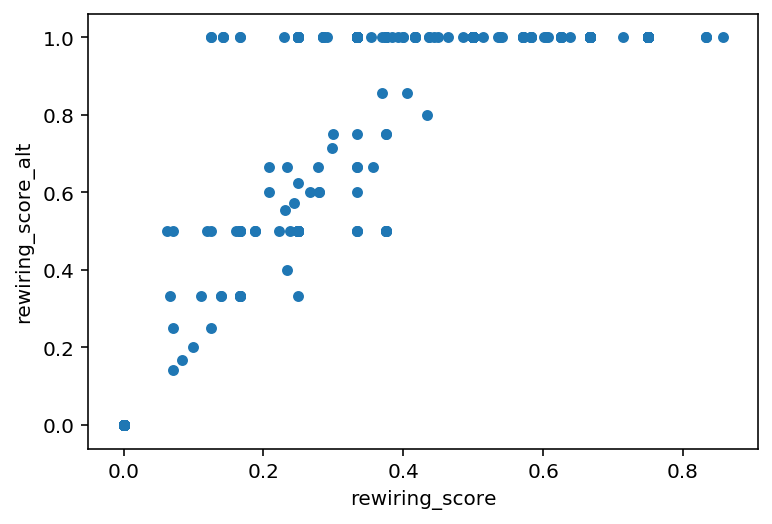

In [180]:
print(partners[['rewiring_score', 'rewiring_score_alt']].corr())
partners.plot.scatter(x='rewiring_score', y='rewiring_score_alt')

In [7]:
cat_columns = [c for c in partners.columns if c.startswith('is_partner_category_')]
partners[cat_columns].sum().sort_values(ascending=False)

is_partner_category_TF                     148
is_partner_category_cofactor                94
is_partner_category_signaling               67
is_partner_category_other                   43
is_partner_category_cytoskeleton            40
is_partner_category_RNA_processing          30
is_partner_category_metabolism              26
is_partner_category_vesicle_transport       24
is_partner_category_protein_turnover        21
is_partner_category_cell_cycle              20
is_partner_category_DNA_repair              13
is_partner_category_cell-cell_signaling      9
is_partner_category_translation              8
is_partner_category_RNA_turnover             6
is_partner_category_membrane_protein         3
is_partner_category_protein_folding          3
is_partner_category_DNA_polymerase           3
is_partner_category_nuclear_transport        2
is_partner_category_DNA_replication          2
is_partner_category_RNA_editing              1
is_partner_category_protein_traffiking       0
dtype: int64

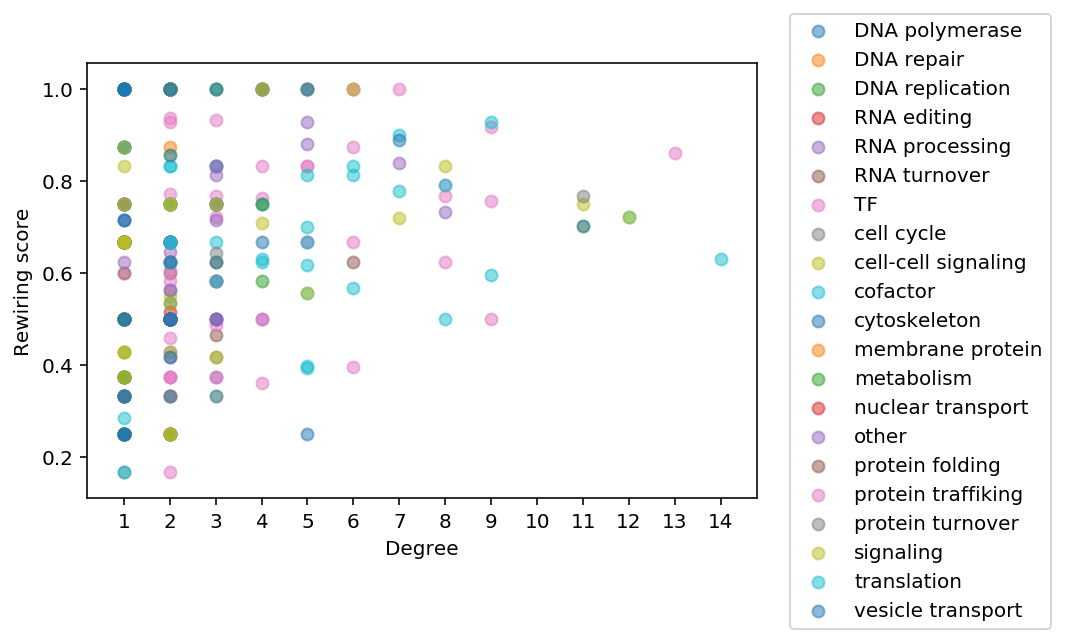

In [8]:
fig, ax = plt.subplots(1, 1)
# order categories by size
for cat in cat_columns:
    ax.scatter(partners.loc[partners[cat],
                             'degree'],
                partners.loc[partners[cat],
                             'rewiring_score'],
               label=cat[len('is_partner_category_'):].replace('_', ' '),
               alpha=0.5)
ax.set_xticks(range(1, partners['degree'].max() + 1))
ax.set_xlabel('Degree')
ax.set_ylabel('Rewiring score')
ax.legend(loc=[1.05, -0.3])

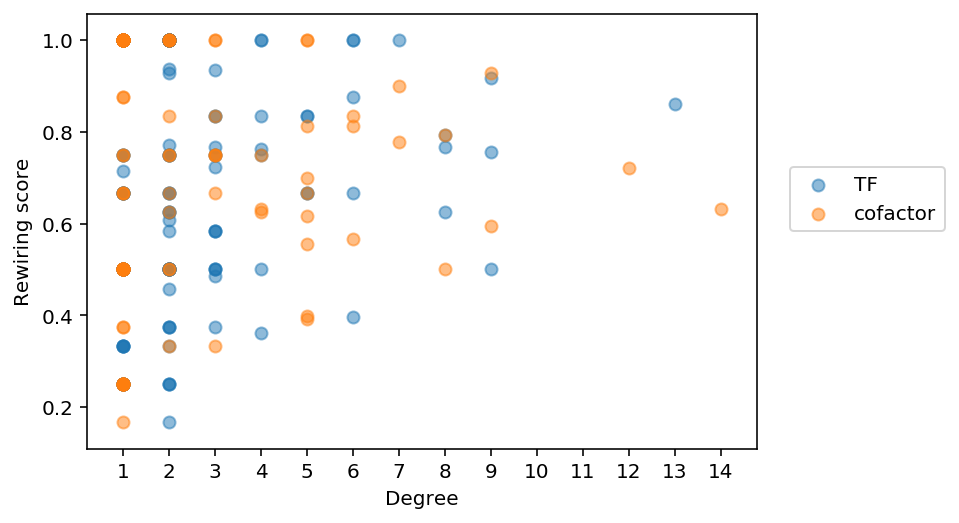

In [9]:
fig, ax = plt.subplots(1, 1)
# order categories by size
min_partners = 75
for cat in cat_columns:
    if partners[cat].sum() < min_partners:
        continue
    ax.scatter(partners.loc[partners[cat],
                             'degree'],
                partners.loc[partners[cat],
                             'rewiring_score'],
               label=cat[len('is_partner_category_'):].replace('_', ' '),
               alpha=0.5)
ax.set_xticks(range(1, partners['degree'].max() + 1))
ax.set_xlabel('Degree')
ax.set_ylabel('Rewiring score')
ax.legend(loc=[1.05, 0.5])

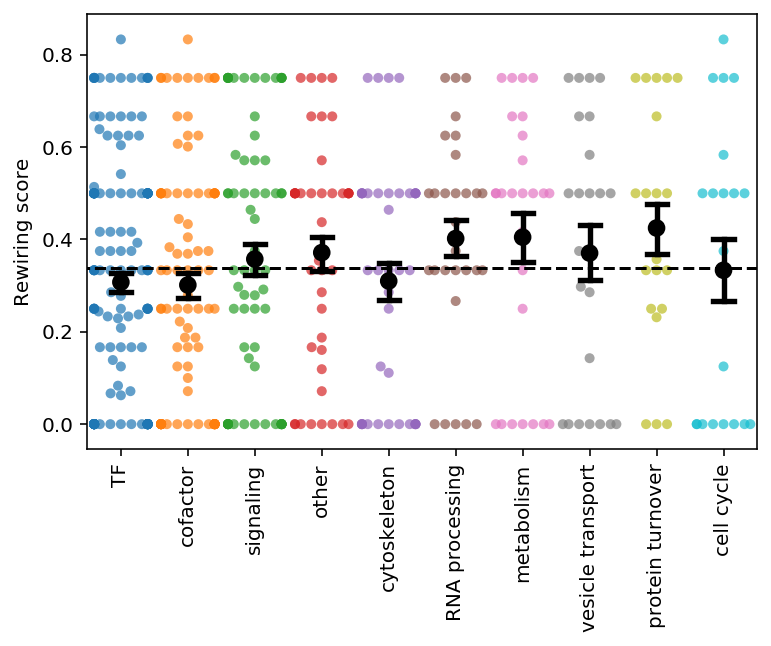

In [181]:
# subset of the larger categories
# merge others into other



x = partners.loc[:, cat_columns].stack()
x = x[x]
x = x.reset_index(level=1).drop(columns=[0])
x['rewiring_score'] = x.index.map(partners['rewiring_score'])
x = x.rename(columns={'level_1': 'category'})
x['category'] = x['category'].apply(lambda x: x[len('in_partner_category_'):].replace('_', ' '))
min_n_category = 20
x = x[x.groupby('category')['rewiring_score'].transform(lambda x: x.shape[0] >= min_n_category)]
fig, ax = plt.subplots(1, 1)
sns.swarmplot(data=x,
              x='category',
              y='rewiring_score',
              order=x.category.value_counts().index.values,
              zorder=-1,
              alpha=0.7,
              ax=ax)
sns.pointplot(data=x,
              x='category',
              y='rewiring_score',
              order=x.category.value_counts().index.values,
              color='black',
              ci=68,
              capsize=0.3,
              linestyles='',
              ax=ax)
ax.axhline(y=partners['rewiring_score'].mean(),
           xmin=ax.get_xlim()[0], xmax=ax.get_xlim()[1],
           linestyle='--', color='black')
#ax.xaxis.set_tick_params(roation=90)
plt.xticks(rotation=90)
ax.set_xlabel('')
ax.set_ylabel('Rewiring score')
plt.savefig('../../figures/rewiring_score_by_category.pdf',
            bbox_inches='tight')

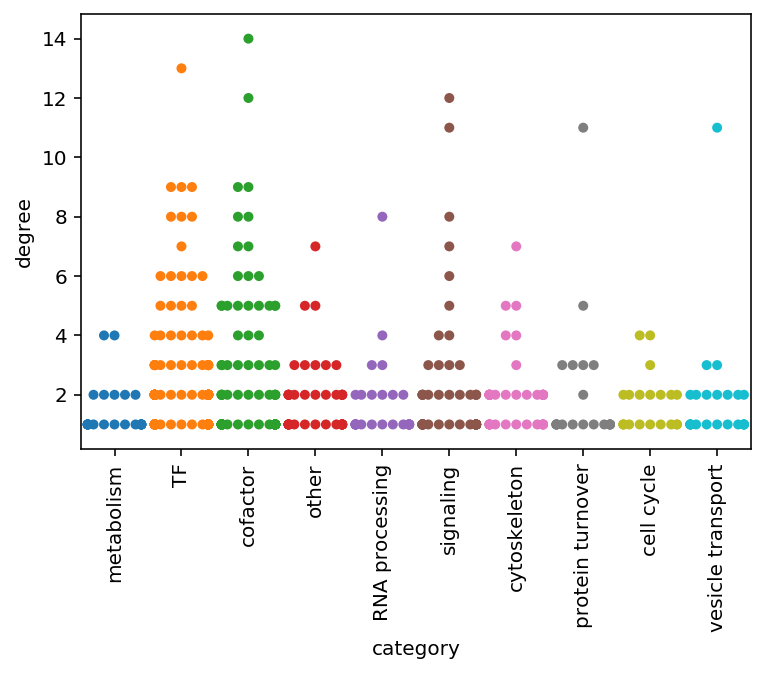

In [119]:
x = partners.loc[:, cat_columns].stack()
x = x[x]
x = x.reset_index(level=1).drop(columns=[0])
x['degree'] = x.index.map(partners['degree'])
x = x.rename(columns={'level_1': 'category'})
x['category'] = x['category'].apply(lambda x: x[len('in_partner_category_'):].replace('_', ' '))
min_n_category = 20
x = x[x.groupby('category')['degree'].transform(lambda x: x.shape[0] >= min_n_category)]
fig, ax = plt.subplots(1, 1)
sns.swarmplot(data=x,
              x='category',
              y='degree',
              ax=ax)
#ax.xaxis.set_tick_params(roation=90)
plt.xticks(rotation=90);

In [11]:
partners['rewiring_score_alt'].mean()

0.3397911520004544

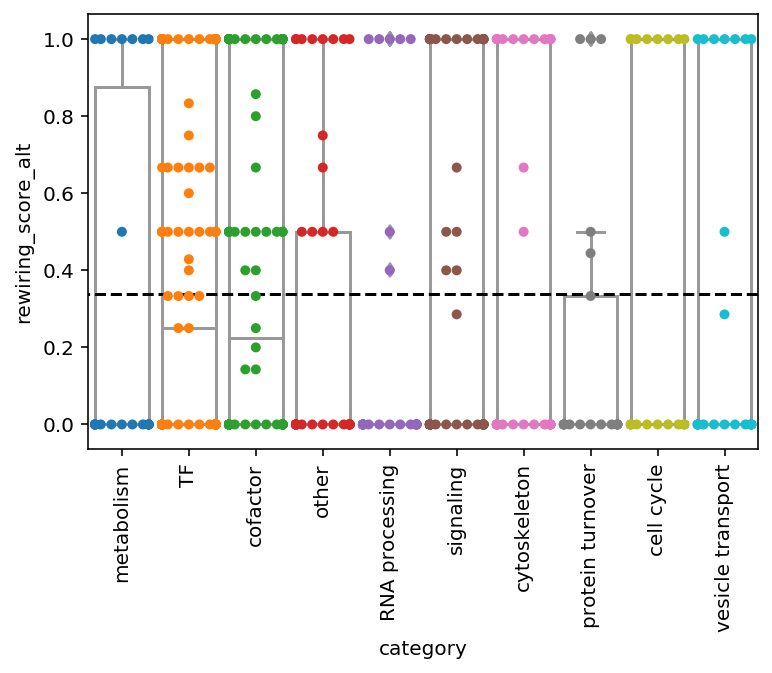

In [12]:
x = partners.loc[:, cat_columns].stack()
x = x[x]
x = x.reset_index(level=1).drop(columns=[0])
x['rewiring_score_alt'] = x.index.map(partners['rewiring_score_alt'])
x = x.rename(columns={'level_1': 'category'})
x['category'] = x['category'].apply(lambda x: x[len('in_partner_category_'):].replace('_', ' '))
min_n_category = 20
x = x[x.groupby('category')['rewiring_score_alt'].transform(lambda x: x.shape[0] >= min_n_category)]
fig, ax = plt.subplots(1, 1)
sns.boxplot(data=x,
              x='category',
              y='rewiring_score_alt',
               color='white',
             ax=ax)
sns.swarmplot(data=x,
              x='category',
              y='rewiring_score_alt',
              ax=ax)
ax.axhline(y=partners['rewiring_score_alt'].mean(),
           xmin=ax.get_xlim()[0], xmax=ax.get_xlim()[1],
           linestyle='--', color='black')
#ax.xaxis.set_tick_params(roation=90)
plt.xticks(rotation=90);

In [15]:
df = pd.read_excel('../../data/20191028- Uniprot functions for interactors.xlsx',
                   sheet_name='Final')
df = df.loc[df['Cofactor type?'].notnull(), ['partner', 'Cofactor type?']]
if df['partner'].duplicated().any():
    raise UserWarning('unexpected duplicates')
cf_type = df.set_index('partner')['Cofactor type?']
x['cofactor_type'] = x.index.map(cf_type)

In [16]:
x[x.category == 'metabolism']

,category,rewiring_score_alt,cofactor_type
db_gene_symbol,,,
ACOT12,metabolism,0.0,NaN
ATP5O,metabolism,0.0,NaN
ATP6V1B2,metabolism,0.0,NaN
ATPAF2,metabolism,1.0,NaN
CBS,metabolism,0.0,NaN
COA5,metabolism,0.0,NaN
COX5B,metabolism,1.0,NaN
FLAD1,metabolism,0.0,NaN
FUCA1,metabolism,1.0,NaN


In [17]:
for cat_col in cat_columns:
    print('{}: {:.4f}'.format(
          cat_col[len('is_partner_category_'):].replace('_', ' '),
          stats.mannwhitneyu(partners.loc[partners[cat_col], 'rewiring_score'].values,
                             partners.loc[~partners[cat_col], 'rewiring_score'].values)[1]))

DNA polymerase: 0.2438
DNA repair: 0.4164
DNA replication: 0.4769
RNA editing: 0.2562
RNA processing: 0.0922
RNA turnover: 0.0232
TF: 0.0527
cell cycle: 0.4940
cell-cell signaling: 0.1826
cofactor: 0.0558
cytoskeleton: 0.2326
membrane protein: 0.3708
metabolism: 0.0779
nuclear transport: 0.2575
other: 0.1709
protein folding: 0.3056
protein traffiking: 0.0000
protein turnover: 0.0790
signaling: 0.2698
translation: 0.1302
vesicle transport: 0.2521


/usr/local/lib/python3.7/site-packages/scipy/stats/stats.py:5700: RuntimeWarning: divide by zero encountered in double_scalars
  z = (bigu - meanrank) / sd


In [78]:
tf_fam = pd.read_csv(os.path.join(ccsblib.ccsblib_cache_dir(),
                                  'data/external/Human_TF_DB_v_1.01.csv'))
tf_fam = tf_fam.loc[tf_fam['Is TF?'] == 'Yes', ['HGNC symbol', 'DBD']]

In [82]:
if tf_fam['HGNC symbol'].duplicated().any():
    raise UserWarning('Unexpected duplicates')
tf_fam = tf_fam.set_index('HGNC symbol')['DBD']

In [182]:
partners['DBD'] = partners.index.map(tf_fam)

In [105]:
partners.DBD.value_counts()

C2H2 ZF                 46
bHLH                    24
Homeodomain             18
bZIP                    11
Unknown                  7
Nuclear receptor         5
HMG/Sox                  4
E2F                      4
C2H2 ZF; AT hook         3
Homeodomain; POU         3
MBD                      3
SMAD                     3
THAP finger              2
Ets                      2
Forkhead                 2
CCCH ZF                  1
Pipsqueak                1
Grainyhead               1
DM                       1
CENPB                    1
C2H2 ZF; BED ZF          1
T-box                    1
AP-2                     1
BED ZF                   1
C2H2 ZF; Homeodomain     1
TBP                      1
TCR/CxC                  1
RFX                      1
Name: DBD, dtype: int64

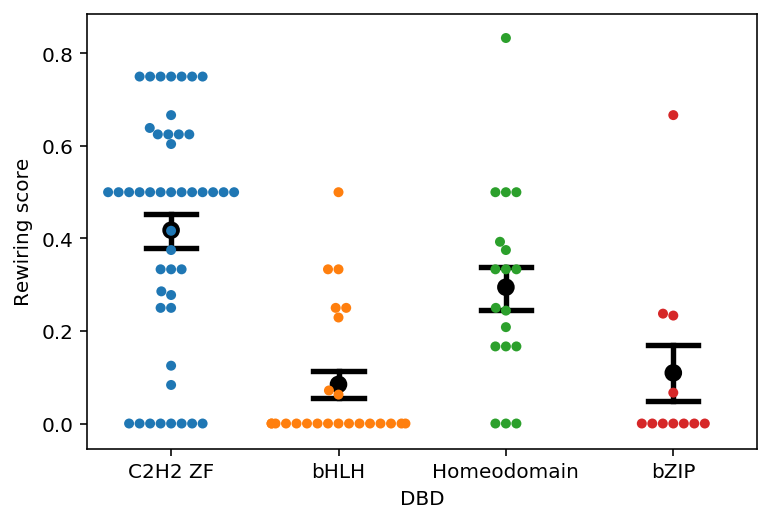

In [183]:
fig, ax = plt.subplots(1, 1)
sns.swarmplot(data=partners.loc[partners['DBD'].isin(['C2H2 ZF', 'bHLH', 'Homeodomain', 'bZIP']), :],
            x='DBD',
            y='rewiring_score',
            order=['C2H2 ZF', 'bHLH', 'Homeodomain', 'bZIP'],
            ax=ax)
sns.pointplot(data=partners.loc[partners['DBD'].isin(['C2H2 ZF', 'bHLH', 'Homeodomain', 'bZIP']), :],
              x='DBD',
              y='rewiring_score',
              order=['C2H2 ZF', 'bHLH', 'Homeodomain', 'bZIP'],
              color='black',
              ci=68,
              capsize=0.3,
              linestyles='',
              ax=ax)
ax.set_ylabel('Rewiring score')
plt.savefig('../../figures/rewiring_score_by_DBD.pdf',
            bbox_inches='tight')

In [178]:
# examples
# ZBTB48
# ZSCAN12
# FIGLA - TCF12, TCF4, LHX6, 
# MSGN1
partners.loc[partners['DBD'] == 'C2H2 ZF', :].sort_values(['rewiring_score', 'degree_filtered'], ascending=[True, False]).head(5)

,rewiring_score,rewiring_score_alt,degree,degree_filtered,is_partner_category_DNA_polymerase,is_partner_category_DNA_repair,is_partner_category_DNA_replication,is_partner_category_RNA_editing,is_partner_category_RNA_processing,is_partner_category_RNA_turnover,is_partner_category_TF,is_partner_category_cell_cycle,is_partner_category_cell-cell_signaling,is_partner_category_cofactor,is_partner_category_cytoskeleton,is_partner_category_membrane_protein,is_partner_category_metabolism,is_partner_category_nuclear_transport,is_partner_category_other,is_partner_category_protein_folding,is_partner_category_protein_traffiking,is_partner_category_protein_turnover,is_partner_category_signaling,is_partner_category_translation,is_partner_category_vesicle_transport,DBD
db_gene_symbol,,,,,,,,,,,,,,,,,,,,,,,,,,
ZSCAN12,0.25,0.0,2,2,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,C2H2 ZF
ZBTB26,0.25,0.0,1,1,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,C2H2 ZF
ZBTB48,0.25,0.0,2,1,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,C2H2 ZF
ZBTB6,0.25,0.0,1,1,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,C2H2 ZF
ZNF264,0.25,0.0,1,1,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,C2H2 ZF


In [169]:
ppi.loc[ppi['db_gene_symbol'] == 'FIGLA', 'ad_gene_symbol'].unique()

array(['TCF12', 'TCF4', 'LHX6'], dtype=object)

In [170]:
ppi.loc[ppi['db_gene_symbol'] == 'MSGN1', 'ad_gene_symbol'].unique()

array(['TCF4', 'ESRRA', 'TCF12'], dtype=object)

In [172]:
ppi.loc[ppi['db_gene_symbol'] == 'ZSCAN12', 'ad_gene_symbol'].unique()

array(['ZNF451', 'ZNF397'], dtype=object)

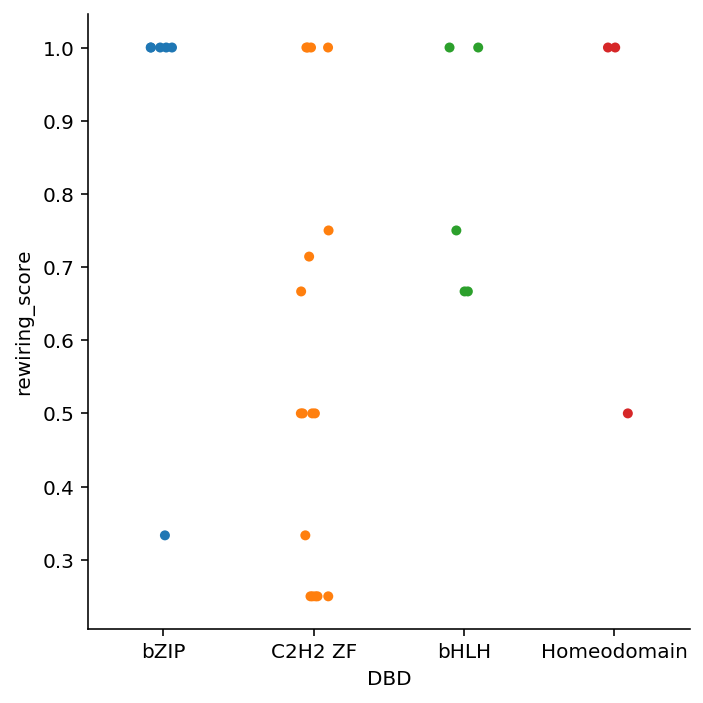

In [108]:
sns.catplot(data=partners.loc[partners['DBD'].isin(['C2H2 ZF', 'bHLH', 'Homeodomain', 'bZIP'])
                              & (partners['degree'] == 1), :],
            x='DBD', y='rewiring_score')

In [160]:
# statisitcal test (6 is Bonferonni for all pairwise)
stats.mannwhitneyu(partners.loc[partners['DBD'] == 'C2H2 ZF', 'rewiring_score'].values,
                   partners.loc[partners['DBD'] == 'bHLH', 'rewiring_score'].values)[1] * 6

3.4518229630984855e-06

In [114]:
stats.mannwhitneyu(partners.loc[(partners['DBD'] == 'C2H2 ZF')
                                & (partners['degree'] == 1),
                                'rewiring_score'].values,
                   partners.loc[(partners['DBD'] == 'bZIP')
                                 & (partners['degree'] == 1),
                                'rewiring_score'].values)

MannwhitneyuResult(statistic=21.5, pvalue=0.017400564241823287)

In [97]:
partners.head()

,degree_gene_level,rewiring_score,is_DNA_polymerase,is_DNA_repair,is_DNA_replication,is_RNA_editing,is_RNA_processing,is_RNA_turnover,is_TF,is_cell_cycle,is_cell-cell_signaling,is_cofactor,is_cytoskeleton,is_membrane_protein,is_metabolism,is_nuclear_transport,is_other,is_protein_folding,is_protein_traffiking,is_protein_turnover,is_signaling,is_translation,is_vesicle_transport,DBD
db_gene_symbol,,,,,,,,,,,,,,,,,,,,,,,,
A1CF,1,0.500000,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,NaN
AC023509.3,1,0.000000,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,bZIP
ACOT12,1,0.750000,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,NaN
AEBP2,1,0.333333,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,C2H2 ZF
AES,7,0.369048,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,NaN


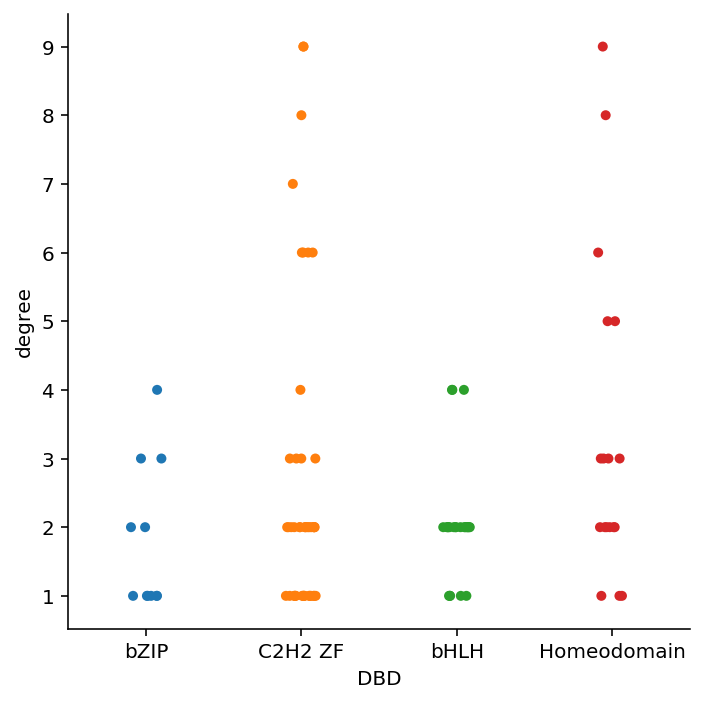

In [115]:
# is it a degree thing?
sns.catplot(data=partners.loc[partners['DBD'].isin(['C2H2 ZF', 'bHLH', 'Homeodomain', 'bZIP']), :],
            x='DBD', y='degree')

In [ ]:
# could take an example of very reqired ZF

In [ ]:
# Is it that ZF are more rewired or the others are less, or both?



In [ ]:
# does it have to do with within DBD family binding vs between DBD family binding?
# heatmap of DBD family PPIs

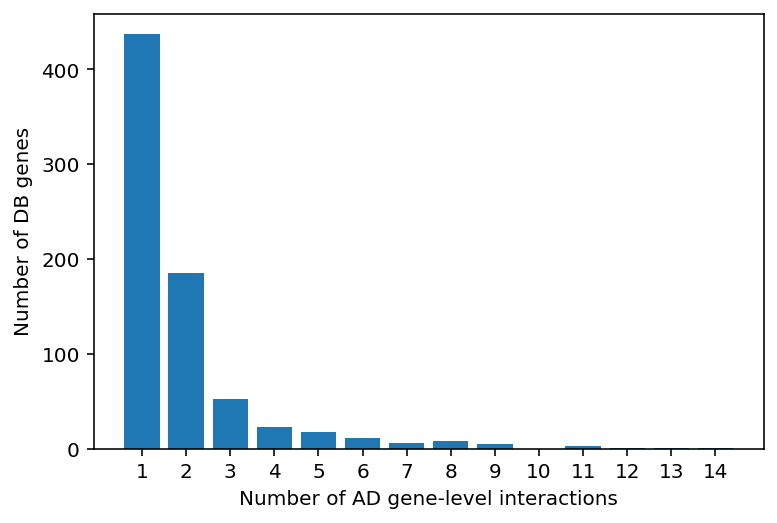

In [19]:
partner_degree = (y2h.loc[(y2h['category'] == 'tf_isoform_ppis') &
                          (y2h['score'] == '1'),
                          ['ad_gene_symbol', 'db_gene_symbol']]
                     .groupby('db_gene_symbol')
                     ['ad_gene_symbol']
                     .nunique())

fig, ax = plt.subplots(1, 1)
db_deg = partner_degree.value_counts()
plt.bar(db_deg.index.values, db_deg.values)
ax.set_xticks(range(1, partner_degree.max() + 1))
ax.set_ylabel('Number of DB genes')
ax.set_xlabel('Number of AD gene-level interactions')
plt.savefig('../../figures/DB_gene_level_degree.pdf',
            bbox_inches='tight')

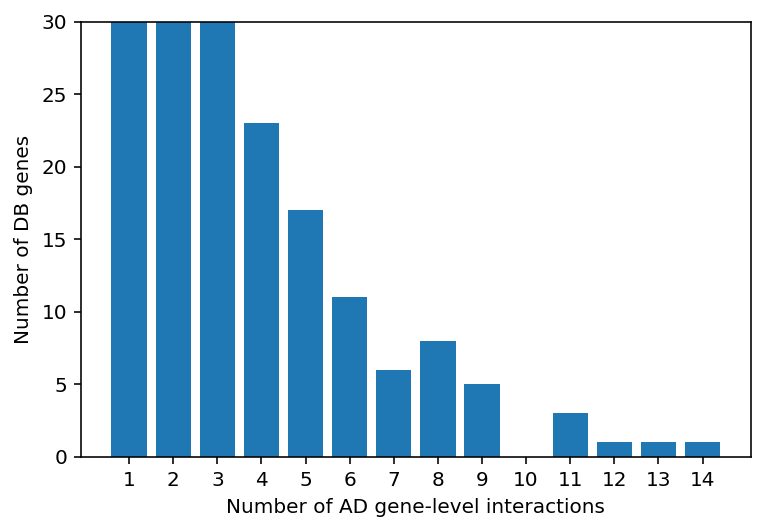

In [20]:
fig, ax = plt.subplots(1, 1)
ax.bar(db_deg.index.values, db_deg.values)
ax.set_xticks(range(1, partner_degree.max() + 1))
ax.set_ylabel('Number of DB genes')
ax.set_xlabel('Number of AD gene-level interactions')
ax.set_ylim(0, 30)
plt.savefig('../../figures/DB_gene_level_degree_zoom.pdf',
            bbox_inches='tight')

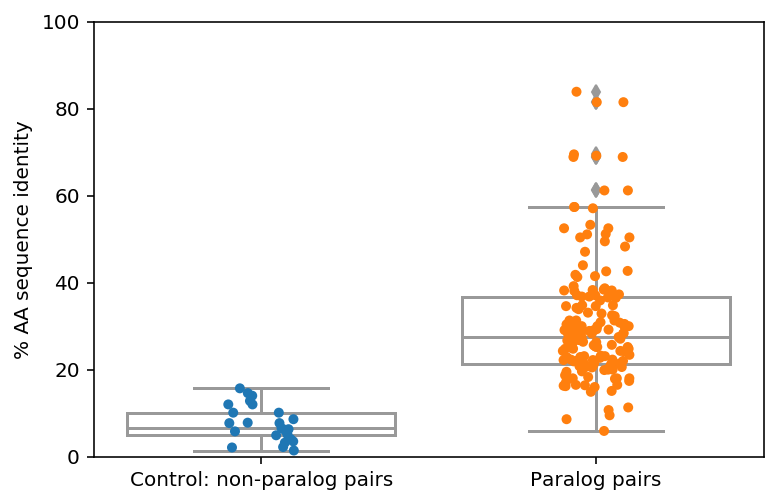

In [22]:
fig, ax = plt.subplots(1, 1)
sns.stripplot(data=pairs, x='is_paralog_pair', y='pct_aa_seq_identity')
sns.boxplot(data=pairs, x='is_paralog_pair', y='pct_aa_seq_identity', color='white')
ax.set_ylim(0, 100)
ax.set_ylabel('% AA sequence identity')
ax.set_xticklabels(['Control: non-paralog pairs', 'Paralog pairs'])
ax.set_xlabel('')
plt.savefig('../../figures/paralog_nonparalog_aa_identity.pdf',
            bbox_inches='tight')

In [23]:
for i, row in pairs.iterrows():
    fig, ax = plt.subplots(1, 1)
    a = row['tf_gene_a']
    b = row['tf_gene_b']
    y2h_ppi_per_paralog_pair_plot(a, b, y2h, ax=ax)
    os.makedirs('../../figures/paralog_pairs', exist_ok=True)
    plt.savefig('../../figures/paralog_pairs/' + a + '_' + b + '.pdf',
                bbox_inches='tight')
    plt.close(fig)

In [24]:
#    - How many partners were negative in all pairwise tests?
a = y2h.loc[(y2h['category'] == 'tf_isoform_ppis'),
           'db_gene_symbol'].nunique()
b = y2h.loc[(y2h['category'] == 'tf_isoform_ppis') &
           (y2h['score'] == '1'),
           'db_gene_symbol'].nunique()
print('Of {} tested partners, {} had at least one positive result'.format(a, b))

Of 914 tested partners, 750 had at least one positive result


In [25]:
a = y2h.loc[(y2h['category'] == 'tf_isoform_ppis'),
           'db_gene_symbol'].unique()
b = y2h.loc[(y2h['category'] == 'tf_isoform_ppis') &
           (y2h['score'] == '1'),
           'db_gene_symbol'].unique()
c = set(a).difference(set(b))
# remove these interactions where none of the isoforms are positive
y2h.loc[(y2h['category'] == 'tf_isoform_ppis') &
        y2h['db_gene_symbol'].isin(c), :].head()

,category,ad_orf_id,ad_clone_acc,ad_gene_symbol,db_orf_id,db_gene_symbol,score,standard_batch,retest_pla,retest_pos,...,is_partner_category_membrane_protein,is_partner_category_metabolism,is_partner_category_nuclear_transport,is_partner_category_other,is_partner_category_protein_folding,is_partner_category_protein_traffiking,is_partner_category_protein_turnover,is_partner_category_signaling,is_partner_category_translation,is_partner_category_vesicle_transport
57,tf_isoform_ppis,101216,GATA1|1/2|08A02,GATA1,1579,TEKT4,0,TFr11,1,A07,...,False,False,False,False,False,False,False,False,False,False
103,tf_isoform_ppis,100301,SMAD3|1/4|06A07,SMAD3,1579,TEKT4,0,TFr07,2,B01,...,False,False,False,False,False,False,False,False,False,False
115,tf_isoform_ppis,100697,SMAD3|4/4|06F07,SMAD3,1579,TEKT4,0,TFr07,2,C01,...,False,False,False,False,False,False,False,False,False,False
126,tf_isoform_ppis,100657,SMAD3|2/4|06G07,SMAD3,1579,TEKT4,0,TFr07,2,D01,...,False,False,False,False,False,False,False,False,False,False
138,tf_isoform_ppis,100479,SMAD3|3/4|06B08,SMAD3,1579,TEKT4,0,TFr09,1,G06,...,False,False,False,False,False,False,False,False,False,False


In [26]:
print('Total TF genes with cloned isoforms: {}'.format(isoforms['gene'].nunique()))
print('Total TF genes with 2+ cloned isoforms: {}'.format(sum((isoforms.groupby('gene').count()>1)['clone_acc'])))
print('with ≥ 1 PPI: {}'.format(y2h.loc[(y2h['category'] == 'tf_isoform_ppis') &
                                        (y2h['score'] == '1'), 
                                        'ad_gene_symbol'].nunique()))
print('with ≥ 2 isoforms with ≥ 1 successuful PPI test for the same partner: {}'
       .format(
        (((y2h.loc[(y2h['category'] == 'tf_isoform_ppis') &
                   y2h['score'].isin(['0', '1']), 
                   :]
              .groupby(['ad_gene_symbol', 'db_gene_symbol'])
              ['ad_clone_acc']
              .nunique() # number of isoforms per partner with valid interactions
              >= 2)
              .reset_index()
              .groupby('ad_gene_symbol').sum() >= 2).sum().iat[0])
     )
)
print('with ≥ 2 isoforms with ≥ 1 PPI each: {}'
       .format(
          (y2h.loc[(y2h['category'] == 'tf_isoform_ppis') &
                   (y2h['score'] == '1'), 
                   :]
              .groupby('ad_gene_symbol')
              ['ad_clone_acc']
              .nunique()
              >= 2).sum()  
         )
     )

Total TF genes with cloned isoforms: 312
Total TF genes with 2+ cloned isoforms: 249
with ≥ 1 PPI: 132
with ≥ 2 isoforms with ≥ 1 successuful PPI test for the same partner: 89
with ≥ 2 isoforms with ≥ 1 PPI each: 71


In [27]:
print('Total TF isoforms: {}'.format(isoforms['clone_acc'].nunique()))
print('with ≥ 1 PPI: {}'.format(y2h.loc[(y2h['category'] == 'tf_isoform_ppis') &
                                        (y2h['score'] == '1'), 
                                        'ad_clone_acc'].nunique()))
print('with ≥ 1 successfully tested PPI: {}'.format(y2h.loc[(y2h['category'] == 'tf_isoform_ppis') &
                                                    y2h['score'].isin(['0', '1']), 
                                                    'ad_clone_acc'].nunique()))

Total TF isoforms: 762
with ≥ 1 PPI: 241
with ≥ 1 successfully tested PPI: 379


In [28]:
ppi.head()

,ad_clone_acc,ad_gene_symbol,db_gene_symbol,score
3,TCF4|8/9|07A05,TCF4,HOXA1,NC
4,ZBTB16|2/2|01D03,ZBTB16,HOXA1,NC
7,HMBOX1|1/5|03A07,HMBOX1,SCNM1,1
13,TCF4|1/9|07E01,TCF4,HOXA1,1
17,ARNT2|2/6|09E01,ARNT2,SCNM1,0


In [29]:
(ppi.shape[0],
 ppi['ad_gene_symbol'].nunique(),
 ppi['ad_clone_acc'].nunique(),
 ppi['db_gene_symbol'].nunique())

(3346, 71, 180, 559)

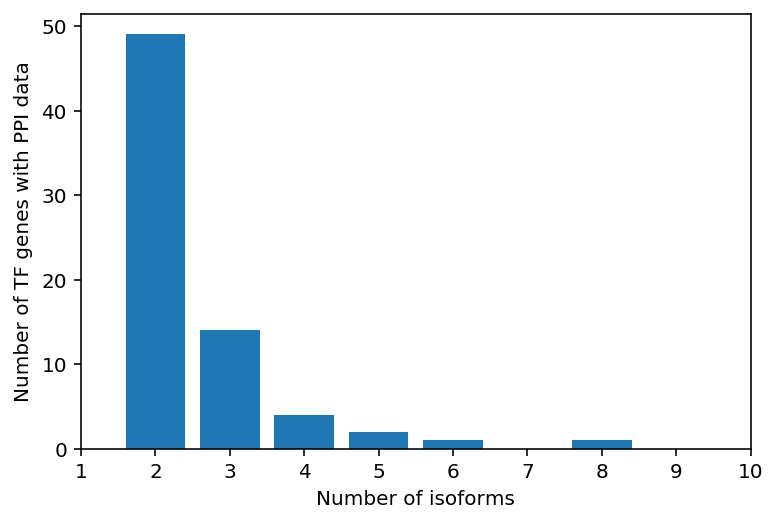

In [30]:
#    - Number of isoforms per TF gene

# remove isoform counts of 1?
n_iso = ppi.groupby('ad_gene_symbol').nunique()['ad_clone_acc']
fig, ax = plt.subplots(1, 1)
ax.bar(n_iso.value_counts().index,
       n_iso.value_counts().values)
ax.set_xticks(range(1, 11))
ax.set_xlabel('Number of isoforms')
ax.set_ylabel('Number of TF genes with PPI data')
plt.savefig('../../figures/n_isoforms_per_gene_with_ppi_data.pdf',
            bbox_inches='tight')

In [31]:
ppi.groupby('ad_gene_symbol').nunique()['db_gene_symbol'].max()

167

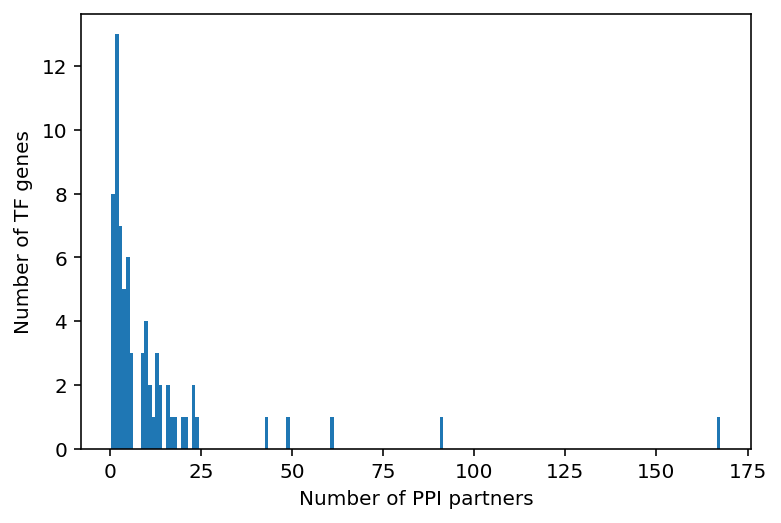

In [32]:
n_ppi = ppi.groupby('ad_gene_symbol').nunique()['db_gene_symbol']
fig, ax = plt.subplots(1, 1)
ax.hist(n_ppi.values, range=(0.5, n_ppi.max() + 0.5), bins=n_ppi.max())
ax.set_xlabel('Number of PPI partners')
ax.set_ylabel('Number of TF genes')
plt.savefig('../../figures/tf_gene_degree.pdf')

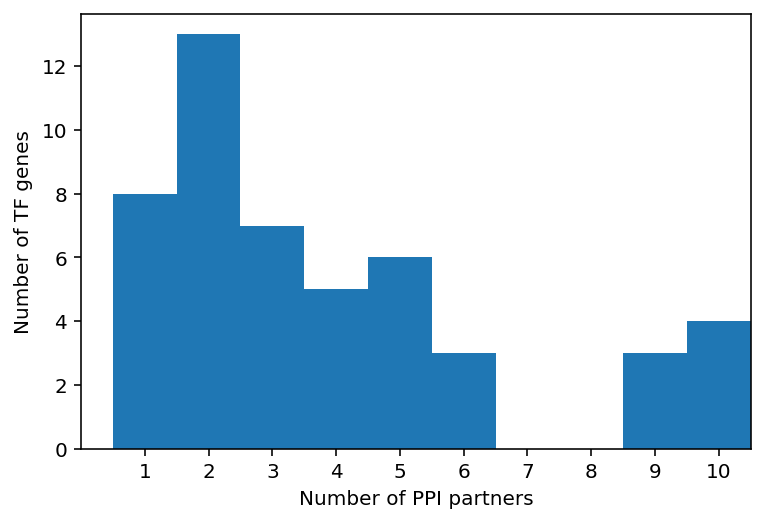

In [33]:
n_ppi = ppi.groupby('ad_gene_symbol').nunique()['db_gene_symbol']
fig, ax = plt.subplots(1, 1)
ax.hist(n_ppi.values, range=(0.5, n_ppi.max() + 0.5), bins=n_ppi.max())
ax.set_xlabel('Number of PPI partners')
ax.set_ylabel('Number of TF genes')
ax.set_xlim(0, 10.5)
ax.set_xticks(range(1, 11))
plt.savefig('../../figures/tf_gene_degree_zoom.pdf')

In [34]:
# classify alternative isoforms by comparing to one with the most interactions
#    (1) all the same 
#    (2) none of those interactions and no others 
#    (3) some of those interactions
#    (4) some additional interactions
# minimum # interactions ?
# this kind-of works but has issues when the ppi with most interacions is tied and there is 

cats = []
for gene_name in ppi['ad_gene_symbol'].unique():
    tf = ppi.loc[(ppi['ad_gene_symbol'] == gene_name),
                ['ad_clone_acc', 'db_gene_symbol', 'score']].copy()
    tf['score'] = tf['score'].map({'1': True,
                               '0': False,
                               'AA': np.nan,
                               'NC': np.nan})
    tf = tf.pivot(index='ad_clone_acc',
                  columns='db_gene_symbol',
                  values='score')
    ref_iso = tf.sum(axis=1).idxmax()
    for iso in tf.index:
        if iso == ref_iso:
            continue
        subset = tf.loc[[ref_iso, iso], 
                        tf.loc[ref_iso, :].notnull() &
                        tf.loc[iso, :].notnull()]    
        if (subset.loc[ref_iso, :] == subset.loc[iso, :]).all():
            cats.append('All same')
        elif subset.loc[iso, subset.columns[subset.loc[ref_iso, :] != True]].any():
            cats.append('Different')
        elif not subset.loc[iso, :].any():
            cats.append('All lost')
        else:
            cats.append('Partially lost')


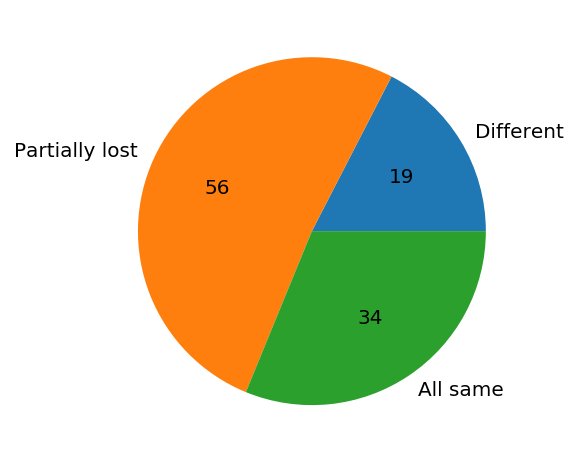

In [35]:
from collections import Counter

counts = Counter(cats)
plt.pie(counts.values(),
        labels=counts.keys(),
        autopct=lambda x: '{:.0f}'.format((x / 100.) * sum(counts.values())))
plt.savefig('../../figures/alt_isoforms_ppis_pie.pdf',
            bbox_inches='tight')

In [36]:
# rewiring fraction
# add category


partners = (ppi.loc[(ppi['score'] == '1'),
                          ['ad_gene_symbol', 'db_gene_symbol']]
                     .groupby('db_gene_symbol')
                     ['ad_gene_symbol']
                     .nunique()).rename('degree_gene_level').to_frame()

df = ppi.copy()
df['score'] = df['score'].map({'1': 1,
                               '0': 0,
                               'AA': np.nan,
                               'NC': np.nan})
# require at least two successful isoform tests per ad gene
df = df.loc[df.groupby(['ad_gene_symbol', 'db_gene_symbol'])
              ['score']
              .transform(lambda x: x.notnull().sum() >= 2),
            :]
partners['rewiring_score'] = 1 - (df.groupby(['ad_gene_symbol', 'db_gene_symbol'])
                                     ['score'].mean().reset_index().groupby('db_gene_symbol').mean())
partners = partners.dropna(subset=['rewiring_score'])
partners.head()

,degree_gene_level,rewiring_score
db_gene_symbol,,
A1CF,1,0.500000
AC023509.3,1,0.000000
ACOT12,1,0.750000
AEBP2,1,0.333333
AES,7,0.369048


SpearmanrResult(correlation=-0.19126319541353903, pvalue=6.911112523155408e-06)


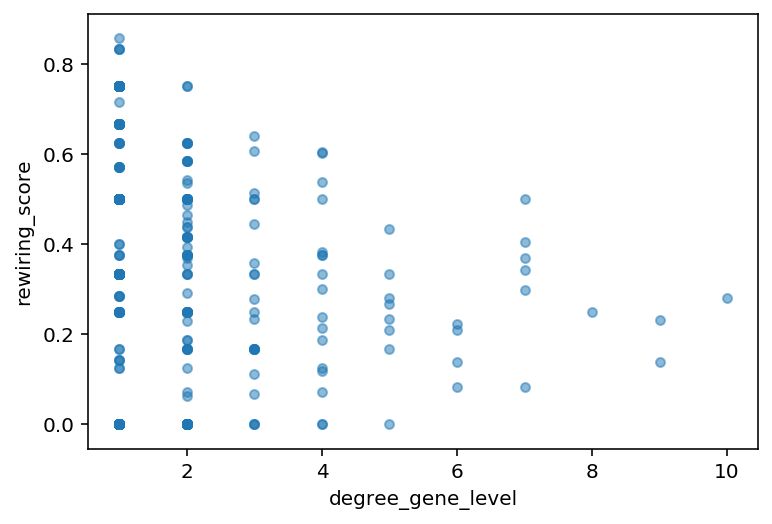

In [37]:
from scipy import stats
print(stats.spearmanr(partners['degree_gene_level'].values, partners['rewiring_score']))
partners.plot.scatter(x='degree_gene_level', 
                      y='rewiring_score',
                      alpha=0.5)

In [38]:
partners.sort_values('rewiring_score', ascending=False)

,degree_gene_level,rewiring_score
db_gene_symbol,,
REXO1L6P,1,0.857143
CRY2,1,0.833333
SPO11,1,0.833333
SIX1,1,0.833333
LCE1E,1,0.750000
CHMP1A,1,0.750000
LCE2C,1,0.750000
THAP1,1,0.750000
UBQLN2,1,0.750000


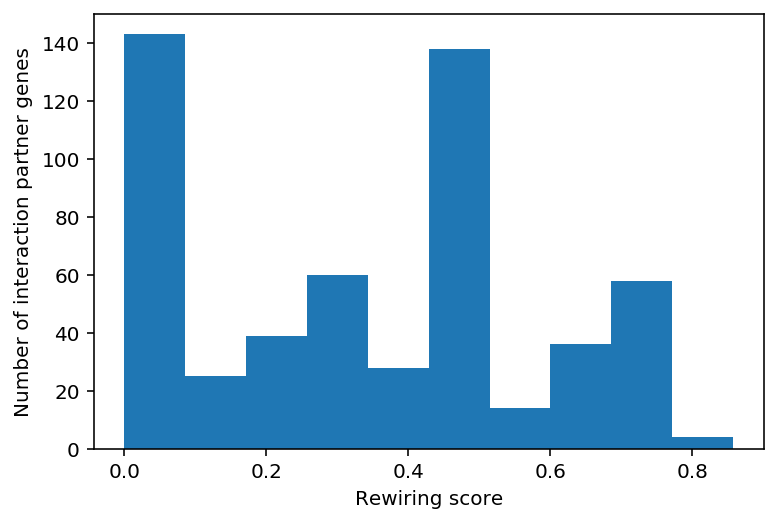

In [39]:
fig, ax = plt.subplots(1, 1)
partners['rewiring_score'].plot.hist()
ax.set_xlabel('Rewiring score')
ax.set_ylabel('Number of interaction partner genes')
plt.savefig('../../figures/rewiring_dist.pdf',
            bbox_inches='tight')

In [40]:
import pandas as pd
def load_ppi_partner_categories():
    """Juan's manual classification of the PPI interaction partners.
    
     Note that a gene can be in multiple categories.
    Returns:
        pandas.DataFrame: gene and category
    
    """
    df = pd.read_excel('../../data/20191023- Uniprot functions for interactors.xlsx', sheet_name='Sheet4')
    df = df.dropna(subset=['Function class'])
    # group annoatations for the same gene split on seperate rows
    df = df.groupby('partner')['Function class'].apply(lambda x: ', '.join(x))
    df = df.str.split(', ', expand=True).stack().reset_index().loc[:, ['partner', 0]].rename(columns={0: 'category'})
    df['category'] = df['category'].str.strip()
    if not (df['partner'] == df['partner'].str.strip()).all():
        raise UserWarning('Possibly something wrong with gene names column')
    return df


partner_cats = load_ppi_partner_categories()
partner_cats.head()

,partner,category
0,A1CF,RNA editing
1,ACKR1,other
2,ACOT12,metabolism
3,ACSM1,metabolism
4,ACTB,cytoskeleton


In [41]:
cats = partner_cats.groupby('category')['partner'].apply(set).to_dict()
for cat, members in cats.items():
    partners['is_' + '_'.join(cat.split())] = partners.index.isin(members)

In [42]:
for col in partners.columns:
    if col.startswith('is_'):
        print(col)
        print(stats.mannwhitneyu(partners.loc[partners[col], 'rewiring_score'].values,
                                 partners.loc[~partners[col], 'rewiring_score'].values))

is_DNA_polymerase
MannwhitneyuResult(statistic=654.0, pvalue=0.2768881070302962)
is_DNA_repair
MannwhitneyuResult(statistic=3251.5, pvalue=0.35452145131065155)
is_DNA_replication
MannwhitneyuResult(statistic=521.5, pvalue=0.4617631535695269)
is_RNA_editing
MannwhitneyuResult(statistic=177.5, pvalue=0.2718911822623195)
is_RNA_processing
MannwhitneyuResult(statistic=6859.5, pvalue=0.14724994631604849)
is_RNA_turnover
MannwhitneyuResult(statistic=904.0, pvalue=0.02955762557010226)
is_TF
MannwhitneyuResult(statistic=26537.0, pvalue=0.07167364379862814)
is_cell_cycle
MannwhitneyuResult(statistic=5131.5, pvalue=0.4311414485328476)
is_cell-cell_signaling
MannwhitneyuResult(statistic=1932.5, pvalue=0.14942990534175998)
is_cofactor
MannwhitneyuResult(statistic=18544.0, pvalue=0.03458278325654247)
is_cytoskeleton
MannwhitneyuResult(statistic=8999.5, pvalue=0.4284677615528491)
is_membrane_protein
MannwhitneyuResult(statistic=740.0, pvalue=0.3932572588390974)
is_metabolism
MannwhitneyuResult(stati

/usr/local/lib/python3.7/site-packages/scipy/stats/stats.py:5700: RuntimeWarning: divide by zero encountered in double_scalars
  z = (bigu - meanrank) / sd


In [43]:
from ccsblib import huri

hiu = huri.load_nw_hi_union(id_type='ensembl_gene_id')
lit = huri.load_nw_lit_17(id_type='ensembl_gene_id')
litb = lit.loc[lit['category'].isin(['Lit-BM', 'Lit-BS']), :].copy()
litbm = lit.loc[lit['category'].isin(['Lit-BM']), :].copy()

def map_gene_names(nw):
    return set(huri.map_nw_ids(nw, 'ensembl_gene_id', 'hgnc_symbol').index)

hiu = map_gene_names(hiu)
lit = map_gene_names(lit)
litbm = map_gene_names(litbm)
litb = map_gene_names(litb)

In [44]:
new_ppis = y2h.loc[(y2h['category'] == 'tf_isoform_ppis') &
                        (y2h['score'] == '1'),
                        ['ad_gene_symbol', 'db_gene_symbol']].drop_duplicates().copy()
new_ppis = set((new_ppis[['ad_gene_symbol', 'db_gene_symbol']].min(axis=1) + '_' +
               new_ppis[['ad_gene_symbol', 'db_gene_symbol']].max(axis=1)).drop_duplicates().values)

In [45]:
print('Total number of PPIs at isoform-level: {}'
        .format(y2h.loc[(y2h['category'] == 'tf_isoform_ppis') &
                        (y2h['score'] == '1'), ].shape[0]))
print('Gene-gene PPIs: {}'.format(len(new_ppis)))
print('Not in HI-Union: {}'.format(len(new_ppis.difference(hiu))))
print('Not in HI-Union or Lit-BM: {}'.format(len(new_ppis.difference(hiu.union(litbm)))))
print('Not in HI-Union or Lit-B: {}'.format(len(new_ppis.difference(hiu.union(litb)))))
print('Not in HI-Union or Lit-NB: {}'.format(len(new_ppis.difference(hiu.union(lit)))))

Total number of PPIs at isoform-level: 2552
Gene-gene PPIs: 1421
Not in HI-Union: 589
Not in HI-Union or Lit-BM: 578
Not in HI-Union or Lit-B: 576
Not in HI-Union or Lit-NB: 546


### TODO

Can we quantify how many additional PPIs we get from studying multiple isoforms relative a single isoform?

We would want to use the screening data, filtered by the pairwise test data, I guess.

Would need to distinguish beetween screening with the same clone twice vs two different isoforms?

## TODO

Plot degree of binding partners vs. fraction of isoforms interacting